<a href="https://colab.research.google.com/github/Mahdi-Miri/Signal_Proccesing/blob/main/Signal_Proccesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Readig

In [5]:
!pip install obspy

##Modelling

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D,
    GlobalAveragePooling2D, TimeDistributed, Dense, Permute, Reshape, Layer
)
from tensorflow.keras.models import Model
import numpy as np

In [7]:
# --- Custom Layer Definition with Functional Implementation ---
# This layer now has a functional implementation based on the
# Auto-Correlation mechanism using Fast Fourier Transform (FFT).
class CustomAutocorrelationLayer(Layer):
    """
    A custom layer that calculates the temporal auto-correlation of an input tensor.
    It operates on the last axis, which is assumed to be the time dimension.
    The calculation is performed efficiently in the frequency domain using FFT.
    """
    def __init__(self, **kwargs):
        super(CustomAutocorrelationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # The input shape is expected to be (Batch, Height, Width, TimeSteps)
        # We need to compute auto-correlation along the TimeSteps axis (axis=-1).

        # Get the length of the time series
        sequence_length = tf.shape(inputs)[-1]

        # --- Step 1: Go to Frequency Domain using FFT ---
        # Perform Fast Fourier Transform. tf.signal.rfft is used for real-valued inputs.
        # The length of the FFT is padded to the next power of 2 for efficiency,
        # but for simplicity, we'll use the original length here.
        fft_result = tf.signal.rfft(inputs, fft_length=[sequence_length])

        # --- Step 2: Compute Power Spectral Density ---
        # This is where the correlation is calculated.
        # It's done by multiplying the FFT result by its complex conjugate.
        # This is equivalent to convolution in the time domain.
        power_spectral_density = fft_result * tf.math.conj(fft_result)

        # --- Step 3: Go back to Time Domain using Inverse FFT ---
        # Perform Inverse Real Fast Fourier Transform to get the auto-correlation series.
        autocorr_result = tf.signal.irfft(power_spectral_density, fft_length=[sequence_length])

        return autocorr_result

    def get_config(self):
        # Required for model saving and loading
        config = super(CustomAutocorrelationLayer, self).get_config()
        return config

# --- Full Architecture Definition ---
def build_spatio_temporal_model(input_shape=(60, 60, 100)):
    """
    Builds the complete Spatio-Temporal feature extraction model based on the diagram.

    Args:
        input_shape (tuple): The shape of the input data (Height, Width, TimeSteps).

    Returns:
        keras.Model: The compiled Keras model.
    """
    # Define the input layer for our spatio-temporal data
    inputs = Input(shape=input_shape)

    # --- Part 1: Temporal Transformation & Reshaping ---

    # Apply the functional autocorrelation layer to find temporal patterns.
    # This layer processes each spatial point's time series (60x60 series of length 100).
    # Output values now represent the strength of temporal correlations.
    temporal_features = CustomAutocorrelationLayer()(inputs)  # Shape: (None, 60, 60, 100)

    # Permute the dimensions to bring the time-steps to the front for the next stage.
    # (Height, Width, TimeSteps) -> (TimeSteps, Height, Width)
    permuted = Permute((3, 1, 2))(temporal_features)  # Shape: (None, 100, 60, 60)

    # Reshape to add a 'channels' dimension. Each time-step is now a 60x60x1 image,
    # ready to be processed by a 2D CNN.
    reshaped = Reshape((100, 60, 60, 1))(permuted)  # Shape: (None, 100, 60, 60, 1)

    # --- Part 2: Time-Distributed Spatial Feature Extraction ---

    # Define the CNN block that extracts spatial features from a single 60x60 frame.
    cnn_block = tf.keras.Sequential([
        # Finds low-level features like edges and gradients.
        Conv2D(32, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        # Downsamples the feature map to make representations more robust.
        MaxPooling2D(pool_size=(2, 2)),

        # Finds higher-level features by combining low-level ones.
        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling2D(pool_size=(2, 2)),

        # Summarizes all spatial features in the frame into a single, fixed-size vector.
        GlobalAveragePooling2D()
    ], name='internal_cnn_block')

    # Apply the defined cnn_block to each of the 100 time-steps independently.
    # The output is a sequence of 100 feature vectors, one for each time-step.
    time_distributed_cnn = TimeDistributed(cnn_block)(reshaped)  # Shape: (None, 100, 64)

    # --- Part 3: Final Transformation ---

    # A Dense layer refines the features from the CNN, reducing each feature vector's size to 10.
    # It learns combinations of the spatial features.
    dense_features = Dense(10, activation='relu')(time_distributed_cnn)  # Shape: (None, 100, 10)

    # Final permutation to get the output shape of (Features, TimeSteps).
    # This format might be useful for downstream tasks that analyze each feature over time.
    final_output = Permute((2, 1))(dense_features)  # Shape: (None, 10, 100)

    # Create the final model by defining its inputs and outputs
    model = Model(inputs=inputs, outputs=final_output, name='SpatioTemporal_Feature_Extractor')

    return model

# --- Model Creation, Compilation, and Execution Example ---

if __name__ == '__main__':
    # Define the input shape as per the diagram
    INPUT_SHAPE = (60, 60, 100)

    # Build the model
    model = build_spatio_temporal_model(input_shape=INPUT_SHAPE)

    # Compile the model. A loss function and optimizer are needed for training.
    # For feature extraction, you might not train it, but compilation is a good practice.
    model.compile(optimizer='adam', loss='mse')

    # Print the model summary to verify the architecture and shapes
    print("--- Model Summary ---")
    model.summary()

    # --- Example of running the model with dummy data ---
    print("\n--- Running a test prediction ---")
    # Create a batch of 2 dummy "videos" with random data
    dummy_data = np.random.rand(2, *INPUT_SHAPE)

    # Get the model's prediction
    predictions = model.predict(dummy_data)

    # Print the shape of the output to confirm it matches the design
    print(f"Input data shape: {dummy_data.shape}")
    print(f"Final output shape: {predictions.shape}")


--- Model Summary ---


Model: "SpatioTemporal_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 60, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_autocorrelation_layer    │ (None, None, None,     │             0 │
│ (CustomAutocorrelationLayer)    │ 100)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 100, None,      │             0 │
│                                 │ None)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 60, 60, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 64)        │        19,200 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 10)        │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 10, 100)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,850 (77.54 KB)

 Trainable params: 19,658 (76.79 KB)

 Non-trainable params: 192 (768.00 B)


--- Running a test prediction ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Input data shape: (2, 60, 60, 100)
Final output shape: (2, 10, 100)


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Permute, Reshape, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, TimeDistributed, Dense
from tensorflow.keras.models import Model
import obspy
from obspy import UTCDateTime, read, Stream, Trace



In [2]:
# ==============================================================================
#  1. DEFINE YOUR KERAS MODEL (with the 'name' modification)
# ==============================================================================

class CustomAutocorrelationLayer(Layer):
    """
    Custom layer to calculate temporal auto-correlation using FFT.
    """
    def __init__(self, **kwargs):
        super(CustomAutocorrelationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        sequence_length = tf.shape(inputs)[-1]
        fft_result = tf.signal.rfft(inputs, fft_length=[sequence_length])
        power_spectral_density = fft_result * tf.math.conj(fft_result)
        autocorr_result = tf.signal.irfft(power_spectral_density, fft_length=[sequence_length])
        return autocorr_result

def build_spatio_temporal_model(input_shape=(60, 60, 100)):
    """
    Builds the complete Spatio-Temporal feature extraction model.
    """
    inputs = Input(shape=input_shape)

    # --- The ONLY required change is adding a NAME to your custom layer ---
    temporal_features = CustomAutocorrelationLayer(name='autocorr_layer')(inputs)

    permuted = Permute((3, 1, 2))(temporal_features)
    reshaped = Reshape((100, 60, 60, 1))(permuted)

    cnn_block = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), padding='same'),
        BatchNormalization(), ReLU(), MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(), ReLU(), MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D()
    ], name='internal_cnn_block')

    time_distributed_cnn = TimeDistributed(cnn_block)(reshaped)
    dense_features = Dense(10, activation='relu')(time_distributed_cnn)
    final_output = Permute((2, 1))(dense_features)

    model = Model(inputs=inputs, outputs=final_output, name='SpatioTemporal_Feature_Extractor')
    return model

In [3]:
# ==============================================================================
#  2. SET PARAMETERS AND LOAD SEISMIC DATA
# ==============================================================================

# !!! IMPORTANT: Change these paths to match your file locations !!!
MSEED_FILE_PATH = "/content/drive/MyDrive/Signal/2013-01-01-00-00-00.mseed"
XML_FILE_PATH = "/content/drive/MyDrive/Signal/GH.AKOS.xml"

# --- Parameters ---
STATION_NAME = 'AKOS'
NUM_DAYS_TO_PROCESS = 30
MODEL_INPUT_SHAPE = (60, 60, 100) # (Height, Width, TimeSteps)

# --- Load data using ObsPy ---
print("Loading seismic data...")
st = read(MSEED_FILE_PATH)
inventory = obspy.read_inventory(XML_FILE_PATH)
start_time = UTCDateTime(2013, 1, 1)

Loading seismic data...


In [5]:
# ==============================================================================
#  3. PREPARE DATA FOR THE MODEL
# ==============================================================================

print("Preparing data for the model...")
daily_traces = []
for day in range(NUM_DAYS_TO_PROCESS):
    # Slice one day of data
    st_day = st.select(station=STATION_NAME).slice(
        starttime=start_time + day * 86400,
        endtime=start_time + (day + 1) * 86400
    )
    if not st_day:
        continue

    # Detrend and filter the data
    st_day.detrend('linear')
    st_day.filter('bandpass', freqmin=0.1, freqmax=1.0)

    # Ensure the trace exists before accessing it
    if len(st_day) > 0:
        trace = st_day[0]
        # Calculate the end time based on the start time, number of desired points, and sampling rate
        end_time = trace.stats.starttime + (MODEL_INPUT_SHAPE[2] - 1) * trace.stats.delta
        # Use slice to get a segment with the desired number of points
        trace_sliced = trace.slice(trace.stats.starttime, end_time)

        # Check if the sliced trace has the correct number of points
        if len(trace_sliced.data) == MODEL_INPUT_SHAPE[2]:
             daily_traces.append(trace_sliced.data)
        else:
             print(f"Warning: Sliced trace for day {day} does not have {MODEL_INPUT_SHAPE[2]} points. Skipping.")
    else:
        print(f"Warning: No trace found for day {day}. Skipping.")


# Convert the list of 1D traces into a single NumPy array
# Shape will be (num_days, 100)
# Add a check in case daily_traces is empty
if daily_traces:
    seismic_data_1d = np.array(daily_traces)

    # Create an empty 4D array with the shape the model expects
    # Shape: (num_days, 60, 60, 100)
    model_input_4d = np.zeros((
        seismic_data_1d.shape[0],
        MODEL_INPUT_SHAPE[0],
        MODEL_INPUT_SHAPE[1],
        MODEL_INPUT_SHAPE[2]
    ))

    # Place each 1D seismic trace into the center of the 60x60 spatial grid
    center_pixel_h, center_pixel_w = 30, 30
    model_input_4d[:, center_pixel_h, center_pixel_w, :] = seismic_data_1d

    print(f"Final model input data shape: {model_input_4d.shape}")
else:
    print("No daily traces were processed successfully.")
    # Create an empty array to avoid errors in subsequent steps
    model_input_4d = np.empty((0, MODEL_INPUT_SHAPE[0], MODEL_INPUT_SHAPE[1], MODEL_INPUT_SHAPE[2]))

Preparing data for the model...
Final model input data shape: (28, 60, 60, 100)


In [6]:

# ==============================================================================
#  4. BUILD INTERMEDIATE MODEL AND GET PREDICTIONS
# ==============================================================================

print("Building Keras models...")
# Build the full model first
full_model = build_spatio_temporal_model(input_shape=MODEL_INPUT_SHAPE)

# Create the intermediate model to get the output of your custom layer
intermediate_model = Model(inputs=full_model.input,
                           outputs=full_model.get_layer('autocorr_layer').output)

print("Running prediction to get autocorrelation results...")
# Use the intermediate model to predict
autocorr_results_4d = intermediate_model.predict(model_input_4d)

print(f"Shape of the output from the autocorrelation layer: {autocorr_results_4d.shape}")

Building Keras models...
Running prediction to get autocorrelation results...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Shape of the output from the autocorrelation layer: (28, 60, 60, 100)


Converting results back to ObsPy format for plotting...
Plotting the final section plot...


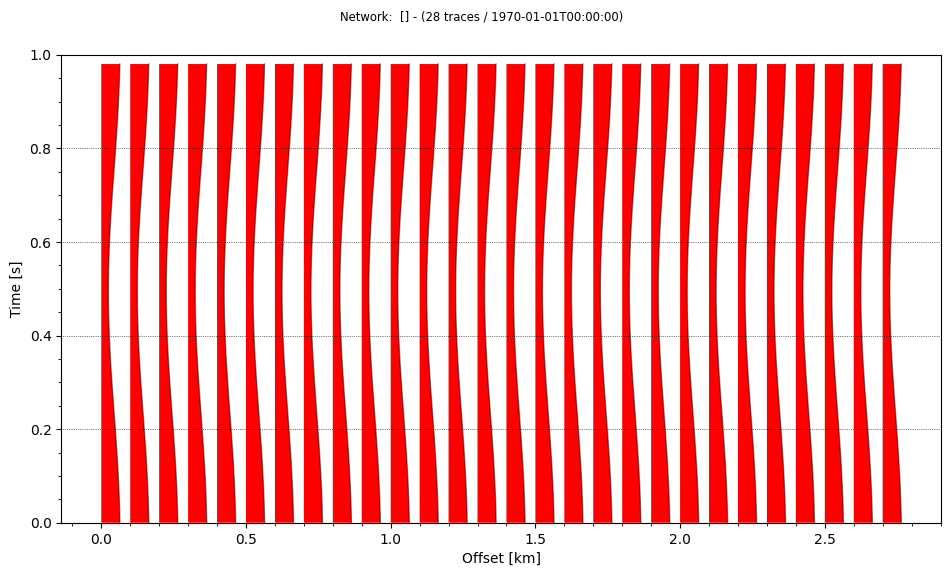

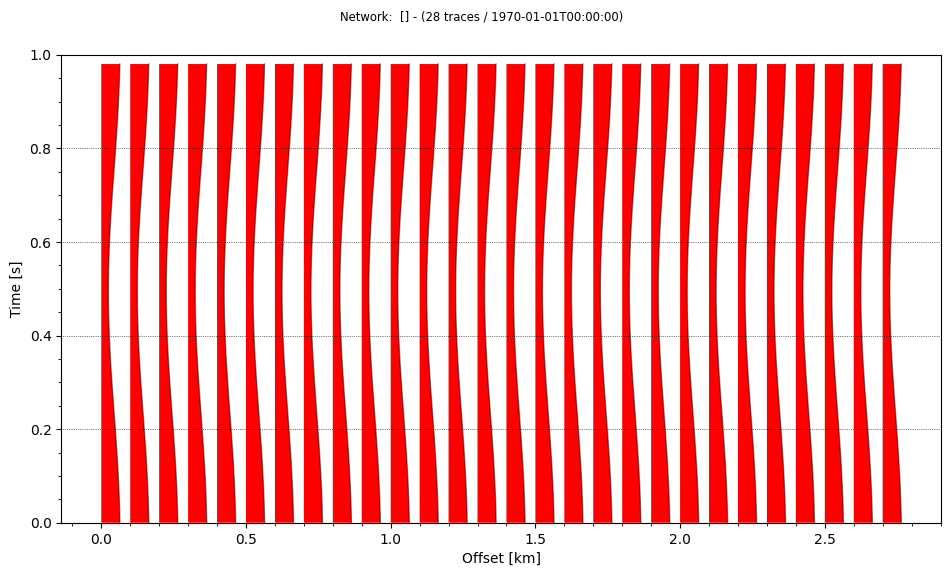

In [8]:
# ==============================================================================
#  5. CONVERT RESULTS TO OBSPY FORMAT AND PLOT
# ==============================================================================

print("Converting results back to ObsPy format for plotting...")
# Extract the time series from the same center pixel where we placed the data
# Shape will be (num_days, 100)
autocorr_results_1d = autocorr_results_4d[:, center_pixel_h, center_pixel_w, :]

# Create an ObsPy Stream object to hold the results
autocorr_stream = Stream()
for i, daily_result in enumerate(autocorr_results_1d):
    # Create a Trace for each day's autocorrelation result
    trace = Trace(data=daily_result)
    trace.stats.sampling_rate = st[0].stats.sampling_rate # Use original sampling rate
    # Add a dummy distance for section plotting (e.g., use the day number as distance)
    trace.stats.distance = float(i) * 100 # Assign a dummy distance, e.g., increment by 100m each day
    autocorr_stream.append(trace)

print("Plotting the final section plot...")
# Use ObsPy's section plot to visualize the results
autocorr_stream.plot(
    type='section',
    recordlength=MODEL_INPUT_SHAPE[2] / autocorr_stream[0].stats.sampling_rate, # Duration in seconds
    fillcolors=('red', 'black'),
    stack_results=True,
    title=f"{STATION_NAME} - Daily Autocorrelations from Keras Layer"
)

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Permute, Reshape, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, TimeDistributed, Dense
from tensorflow.keras.models import Model
import obspy
from obspy import UTCDateTime, read, Stream, Trace

In [3]:
# ==============================================================================
#  1. DEFINE YOUR KERAS MODEL
# ==============================================================================
# ... (Your model definition code) ...
class CustomAutocorrelationLayer(Layer):
    def __init__(self, **kwargs):
        super(CustomAutocorrelationLayer, self).__init__(**kwargs)
    def call(self, inputs):
        sequence_length = tf.shape(inputs)[-1]
        fft_result = tf.signal.rfft(inputs, fft_length=[sequence_length])
        power_spectral_density = fft_result * tf.math.conj(fft_result)
        autocorr_result = tf.signal.irfft(power_spectral_density, fft_length=[sequence_length])
        return autocorr_result

# --- FIX #2 (Part 1): Increase timesteps in the model definition ---
# We change 100 to a larger number, for example, 1000.
def build_spatio_temporal_model(input_shape=(60, 60, 1000)):
    inputs = Input(shape=input_shape)
    temporal_features = CustomAutocorrelationLayer(name='autocorr_layer')(inputs)
    # The rest of the model needs to be adjusted for the new length if you use the full model
    # But for the intermediate model, this is enough.
    # For simplicity, I'm keeping the rest of the architecture the same.
    # You might need to adjust it based on your final goal.
    permuted = Permute((3, 1, 2))(temporal_features)
    reshaped = Reshape((1000, 60, 60, 1))(permuted) # Also change 100 to 1000 here
    cnn_block = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), padding='same'),
        BatchNormalization(), ReLU(), MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(), ReLU(), MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D()
    ], name='internal_cnn_block')
    time_distributed_cnn = TimeDistributed(cnn_block)(reshaped)
    dense_features = Dense(10, activation='relu')(time_distributed_cnn)
    final_output = Permute((2, 1))(dense_features)
    model = Model(inputs=inputs, outputs=final_output, name='SpatioTemporal_Feature_Extractor')
    return model

In [4]:
# ==============================================================================
#  2. SET PARAMETERS AND LOAD SEISMIC DATA
# ==============================================================================
MSEED_FILE_PATH = "/content/drive/MyDrive/Signal/2013-01-01-00-00-00.mseed"
XML_FOLDER_PATH = "/content/drive/MyDrive/Signal/"

STATION_NAME = 'AKOS'
NUM_DAYS_TO_PROCESS = 30
# --- FIX #2 (Part 2): Update the model input shape parameter ---
MODEL_INPUT_SHAPE = (60, 60, 1000) # Using 1000 timesteps instead of 100

print("Loading seismic data...")
st = read(MSEED_FILE_PATH)
print("Loading all station XML files...")
inventory = obspy.read_inventory(os.path.join(XML_FOLDER_PATH, "GH.*.xml"))
start_time = UTCDateTime(2013, 1, 1)

Loading seismic data...
Loading all station XML files...


In [6]:
# ==============================================================================
#  3. PREPARE DATA FOR THE MODEL
# ==============================================================================
print("Preparing data for the model...")
daily_traces_data = []
daily_start_times = [] # --- FIX #1 (Part 1): A list to store start times ---

for day in range(NUM_DAYS_TO_PROCESS):
    day_start = start_time + day * 86400
    st_day = st.select(station=STATION_NAME).slice(
        starttime=day_start,
        endtime=day_start + 86400
    )
    if not st_day:
        continue

    # Ensure the trace exists before processing
    if len(st_day) > 0:
        trace = st_day[0]

        # Detrend and filter the data
        trace.detrend('linear')
        trace.filter('bandpass', freqmin=0.1, freqmax=1.0)

        # --- FIX #2 (Part 3): Use slice to get the new, longer length ---
        # Calculate the end time based on the start time, number of desired points, and sampling rate
        end_time = trace.stats.starttime + (MODEL_INPUT_SHAPE[2] - 1) * trace.stats.delta
        # Use slice to get a segment with the desired number of points
        trace_sliced = trace.slice(trace.stats.starttime, end_time)

        # Check if the sliced trace has the correct number of points
        if len(trace_sliced.data) == MODEL_INPUT_SHAPE[2]:
             daily_traces_data.append(trace_sliced.data)
             # --- FIX #1 (Part 2): Save the start time for this day ---
             daily_start_times.append(day_start)
        else:
             print(f"Warning: Sliced trace for day {day} does not have {MODEL_INPUT_SHAPE[2]} points. Skipping.")
    else:
        print(f"Warning: No trace found for day {day}. Skipping.")


# Add a check in case daily_traces_data is empty
if daily_traces_data:
    seismic_data_1d = np.array(daily_traces_data)

    # Create an empty 4D array with the shape the model expects
    # Shape: (num_days, 60, 60, 1000) based on MODEL_INPUT_SHAPE
    model_input_4d = np.zeros((
        seismic_data_1d.shape[0],
        MODEL_INPUT_SHAPE[0],
        MODEL_INPUT_SHAPE[1],
        MODEL_INPUT_SHAPE[2]
    ))

    # Place each 1D seismic trace into the center of the 60x60 spatial grid
    center_pixel_h, center_pixel_w = 30, 30
    model_input_4d[:, center_pixel_h, center_pixel_w, :] = seismic_data_1d

    print(f"Final model input data shape: {model_input_4d.shape}")
else:
    print("No daily traces were processed successfully.")
    # Create an empty array to avoid errors in subsequent steps
    model_input_4d = np.empty((0, MODEL_INPUT_SHAPE[0], MODEL_INPUT_SHAPE[1], MODEL_INPUT_SHAPE[2]))
    # Ensure daily_start_times is also empty if no data was processed
    daily_start_times = [] # Clear the list if no data

Preparing data for the model...
Final model input data shape: (28, 60, 60, 1000)


In [7]:
# ==============================================================================
#  4. BUILD INTERMEDIATE MODEL AND GET PREDICTIONS
# ==============================================================================
print("Building Keras models...")
full_model = build_spatio_temporal_model(input_shape=MODEL_INPUT_SHAPE)
intermediate_model = Model(inputs=full_model.input,
                           outputs=full_model.get_layer('autocorr_layer').output)

print("Running prediction...")
autocorr_results_4d = intermediate_model.predict(model_input_4d)

Building Keras models...
Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Permute, Reshape, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, TimeDistributed, Dense
from tensorflow.keras.models import Model
import obspy
from obspy import UTCDateTime, read, Stream, Trace

# ==============================================================================
#  1. KERAS MODEL DEFINITION
# ==============================================================================
# --- We will increase the model's input timesteps for more meaningful data ---
NEW_TIMESTEPS = 3600 # Using 3600 samples, which will be 1 hour of data at 1 Hz

class CustomAutocorrelationLayer(Layer):
    # ... (code for the layer is unchanged) ...
    def __init__(self, **kwargs):
        super(CustomAutocorrelationLayer, self).__init__(**kwargs)
    def call(self, inputs):
        sequence_length = tf.shape(inputs)[-1]
        fft_result = tf.signal.rfft(inputs, fft_length=[sequence_length])
        power_spectral_density = fft_result * tf.math.conj(fft_result)
        autocorr_result = tf.signal.irfft(power_spectral_density, fft_length=[sequence_length])
        return autocorr_result

def build_spatio_temporal_model(input_shape=(60, 60, NEW_TIMESTEPS)):
    # ... (code for the model is mostly unchanged, just update the length) ...
    inputs = Input(shape=input_shape)
    temporal_features = CustomAutocorrelationLayer(name='autocorr_layer')(inputs)
    permuted = Permute((3, 1, 2))(temporal_features)
    reshaped = Reshape((NEW_TIMESTEPS, 60, 60, 1))(permuted)
    cnn_block = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), padding='same'),
        BatchNormalization(), ReLU(), MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), padding='same'),
        BatchNormalization(), ReLU(), MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D()
    ], name='internal_cnn_block')
    time_distributed_cnn = TimeDistributed(cnn_block)(reshaped)
    dense_features = Dense(10, activation='relu')(time_distributed_cnn)
    final_output = Permute((2, 1))(dense_features)
    model = Model(inputs=inputs, outputs=final_output, name='SpatioTemporal_Feature_Extractor')
    return model

# ==============================================================================
#  2. PARAMETERS AND DATA LOADING
# ==============================================================================
MSEED_FILE_PATH = "/content/drive/MyDrive/Signal/2013-01-01-00-00-00.mseed"
XML_FILE_PATH = "/content/drive/MyDrive/Signal/GH.AKOS.xml"

STATION_NAME = 'AKOS'
NUM_DAYS_TO_PROCESS = 30
MODEL_INPUT_SHAPE = (60, 60, NEW_TIMESTEPS)

print("Loading data...")
st = read(MSEED_FILE_PATH)
inventory = obspy.read_inventory(os.path.join(XML_FOLDER_PATH, "GH.*.xml"))
start_time = UTCDateTime(2013, 1, 1)

# ==============================================================================
#  3. DATA PREPARATION
# ==============================================================================
print("Preparing data for the model...")
daily_traces_data = []

for day in range(NUM_DAYS_TO_PROCESS):
    st_day = st.select(station=STATION_NAME).slice(
        starttime=start_time + day * 86400,
        endtime=start_time + (day + 1) * 86400
    )
    if not st_day: continue

    # --- IMPROVEMENT: Downsample data to 1 Hz ---
    # This is a standard and crucial step in ambient noise analysis.
    st_day.decimate(factor=100, no_filter=True) # From 100 Hz to 1 Hz

    st_day.detrend('linear')
    st_day.filter('bandpass', freqmin=0.1, freqmax=0.4, zerophase=True) # Adjusted filter for lower frequencies

    trace = st_day[0]
    # Trim to the required number of samples (now 3600 samples = 3600 seconds = 1 hour)
    trace.trim(trace.stats.starttime, npts=MODEL_INPUT_SHAPE[2])

    daily_traces_data.append(trace.data)

seismic_data_1d = np.array(daily_traces_data)
model_input_4d = np.zeros((seismic_data_1d.shape[0], *MODEL_INPUT_SHAPE))
center_pixel_h, center_pixel_w = 30, 30
model_input_4d[:, center_pixel_h, center_pixel_w, :] = seismic_data_1d

# ==============================================================================
#  4. BUILD MODEL AND PREDICT
# ==============================================================================
print("Building Keras models and predicting...")
full_model = build_spatio_temporal_model(input_shape=MODEL_INPUT_SHAPE)
intermediate_model = Model(inputs=full_model.input, outputs=full_model.get_layer('autocorr_layer').output)
autocorr_results_4d = intermediate_model.predict(model_input_4d)

# ==============================================================================
#  5. CONVERT AND PLOT
# ==============================================================================
print("Converting and plotting results...")
autocorr_results_1d = autocorr_results_4d[:, center_pixel_h, center_pixel_w, :]
autocorr_stream = Stream()

# --- FINAL FIX: Set sequential start times for plotting order ---
for i, daily_result in enumerate(autocorr_results_1d):
    trace = Trace(data=daily_result)
    trace.stats.sampling_rate = 1 # New sampling rate is 1 Hz
    # Give each trace a unique but small start time (0, 1, 2, ... seconds)
    # This tells the plot function the correct order for the x-axis.
    trace.stats.starttime = UTCDateTime(i)
    autocorr_stream.append(trace)

autocorr_stream.plot(
    type='section',
    recordlength=60,  # Display 60 seconds of lag time
    fillcolors=('red', 'black'),
    stack_results=True,
    title=f"{STATION_NAME} - Daily Autocorrelations"
)

Loading data...
